# Week-ahead Prediction Accuracy

In this notebook I hope to illustrate the differences between week-ahead prediction accuracies for Random Forest models trained in the same way over time.

In [18]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tscv import GapRollForward
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor

In [19]:
df = pd.read_csv('../data/sa/merged_interpolated.csv')
df.datetime = df.datetime.astype('datetime64')
df.head()

,datetime,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est,net_load,total_load
0,2018-03-06 09:30:00,20.75,2.5,14.5,135.0,44.5,0.0,1915.0,318.991,1288,1136.79
1,2018-03-06 10:00:00,21.50,1.0,16.0,140.0,40.0,0.0,2340.0,375.231,1237,1054.87
2,2018-03-06 10:30:00,22.25,1.5,15.5,145.0,37.0,0.0,2570.0,430.909,1189,1002.35
3,2018-03-06 11:00:00,23.00,2.0,15.0,150.0,34.0,0.0,2800.0,485.129,1150,971.54
4,2018-03-06 11:30:00,23.55,2.0,13.0,145.0,32.0,0.0,2945.0,523.989,1122,943.68


Expand datetime feature to its various component parts, plus day of week and week of year.

In [20]:
dt = df['datetime'].astype('datetime64[ns]').dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['day_of_week'] = dt.day_of_week
df['week'] = dt.isocalendar().week
df.dtypes

datetime       datetime64[ns]
tempc                 float64
cloud8                float64
windk                 float64
wdir                  float64
humid                 float64
rainmm                float64
radkjm2               float64
pv_est                float64
net_load                int64
total_load            float64
year                    int64
month                   int64
day                     int64
hour                    int64
minute                  int64
day_of_week             int64
week                   UInt32
dtype: object

Select training features and extract training matrix X and response y.

In [21]:
X_inds = list(range(1, 8)) + list(range(11, 18))
y_ind = 9
X = df.iloc[:, X_inds].to_numpy()
y = df.iloc[:, 9].to_numpy()

print(X.shape, y.shape)
df.columns[X_inds], df.columns[y_ind]

(87726, 14) (87726,)


(Index(['tempc', 'cloud8', 'windk', 'wdir', 'humid', 'rainmm', 'radkjm2',
        'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'week'],
       dtype='object'),
 'net_load')

Cross-validation splits are done in an appropriate time-series fashion, with one observation-year (48 observations \* 365 days) for each training set and test set. There should be a good number of splits with a roll size (gap between successive training set starting points) of 30 days.

In [22]:
obs_year = 48*365
tscv = GapRollForward(min_train_size=obs_year, max_train_size=obs_year,
                      min_test_size=obs_year, max_test_size=obs_year,
                      roll_size=48*30)
n_splits = sum(1 for i in tscv.split(df)) # get length of a generator

print('Number of models to be trained:', n_splits)

Number of models to be trained: 37


Training of each forest is parallelised to save time, but even so the full training takes a few minutes. No hyperparameters are selected or tuned. Models and their last training observation's timestamps are saved.

Predictions are made on a full ensuing year per model and merged into a single dataframe, with calculated residuals and absolute percentage error.

In [23]:
#warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
predictions_filename = '../outputs/rf_year_ahead.csv'
try:
    predictions = pd.read_csv(predictions_filename)
except FileNotFoundError:
    #models, train_ends = [], []
    prdfs = []

    for i, (train_ind, test_ind) in tqdm(enumerate(tscv.split(df))):
        X_train, X_test = df.iloc[train_ind, X_inds], df.iloc[test_ind, X_inds]
        y_train, y_test = df.iloc[train_ind, y_ind], df.iloc[test_ind, y_ind]

        # train
        rf = RandomForestRegressor(n_jobs=8)
        rf.fit(X_train, y_train)
        #models.append(rf)
        #train_ends.append(df.loc[train_ind[-1], 'datetime'])

        # predict
        prd = rf.predict(X_test)
        prdf = pd.DataFrame({'datetime': df.loc[test_ind, 'datetime'], 
                            'model': i,
                            'obs_ahead': np.arange(len(prd)) + 1,
                            'predicted': prd,
                            'net_load': df.loc[test_ind, 'net_load']})
        prdfs.append(prdf)
    predictions = pd.concat(prdfs)
    predictions.to_csv(predictions_filename, index=False)

predictions['residual'] = predictions['net_load'] - predictions['predicted']
predictions['ape'] = predictions['residual'].abs() / predictions['net_load']
predictions

0it [00:00, ?it/s]

,datetime,model,obs_ahead,predicted,net_load,residual,ape
17520,2019-03-06 09:30:00,0,1,1406.89,1379,-27.89,0.020225
17521,2019-03-06 10:00:00,0,2,1383.16,1312,-71.16,0.054238
17522,2019-03-06 10:30:00,0,3,1358.00,1216,-142.00,0.116776
17523,2019-03-06 11:00:00,0,4,1280.10,1209,-71.10,0.058809
17524,2019-03-06 11:30:00,0,5,1274.14,1152,-122.14,0.106024
...,...,...,...,...,...,...,...
86875,2023-02-18 07:00:00,36,17516,1195.45,1289,93.55,0.072576
86876,2023-02-18 07:30:00,36,17517,1143.17,1232,88.83,0.072102
86877,2023-02-18 08:00:00,36,17518,1002.09,1136,133.91,0.117879
86878,2023-02-18 08:30:00,36,17519,917.69,996,78.31,0.078624


Now calculate and plot mape for each model

<Axes: xlabel='model', ylabel='ape'>

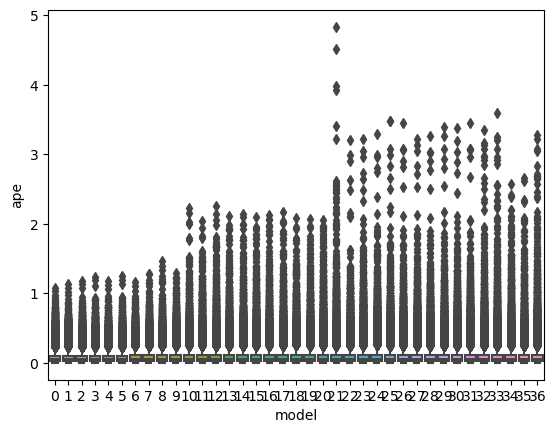

In [24]:
sns.boxplot(predictions, x='model', y='ape')

Plot absolute percentage error quartiles over time/models.

<Axes: xlabel='model'>

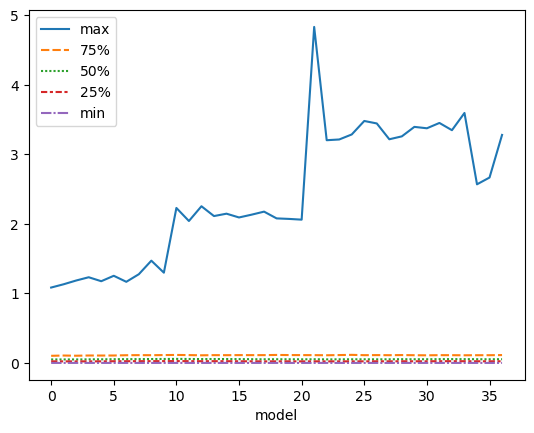

In [25]:
sns.lineplot(predictions.groupby('model').describe()['ape'][['max', '75%', '50%', '25%', 'min']])

Plot residual quantiles over time/models.

<Axes: xlabel='model'>

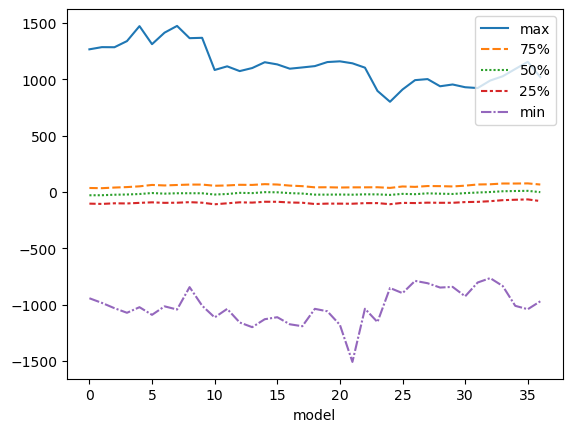

In [26]:
sns.lineplot(predictions.groupby('model').describe()['residual'][['max', '75%', '50%', '25%', 'min']])

Use all models to predict the final week of observations.

In [27]:
test_cutoff = df['datetime'].max() - pd.DateOffset(weeks=1)

df['datetime'].max(), test_cutoff

(Timestamp('2023-03-08 00:00:00'), Timestamp('2023-03-01 00:00:00'))